In [1]:
# is this the folder with the script in it?
scriptDir<-getwd()
scriptDir

# if not, uncomment and use this instead
# scriptDir<-""

[1] "/Users/anyaemerson/Documents/RRIV/SensorDataProcessing/rriv_methane"

In [2]:
methaneFunctions<-paste(scriptDir,"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/Users/anyaemerson/Documents/RRIV/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [3]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis", "gam", "ggeffects", "reshape2", "mgcv")
packageHandler(packages)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: viridisLite

Loading required package: splines

Loading required package: foreach

Loaded gam 1.22-2


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1

# 1. Import data from directory(ies):

In [15]:
directory1<-"~/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/20230531-cold"
directory2<-"~/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/20230531-cold-hot"
directory3<-"~/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/20230601"
directory4<-"~/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/20230602-hot"

# 2. Create output directory:

In [16]:
# create output directory path based on input directory
# outputDir<-paste0(directory3,"_output")
outputDir<-"~/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output"
# create the output directory if necessary
newDir(dirPath = outputDir)

Output directory, ~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output, already exists


# save plot function

In [8]:
savePlot<-function(plot, tag="",width=800,height=800,od=outputDir){
    if(substr(od, nchar(od), nchar(od)) != "/"){ od<-paste0(od,"/") }
        pngPath = paste0(od, deparse(substitute(plot)), tag,"_", ".png")
        png(file = pngPath, width=width, height=height)
        print(plot)
        dev.off()
}

# 3. Read in data from both RRIV and LGR
note: can separate paths for LGR and RRIV if you want, but concat_dirs should work anyways making use of the filePattern argument

In [7]:
# list.files(directory, recursive = TRUE)

In [22]:
# read_rriv_CSV eliminates debug lines and lines where the logger is NA
rriv_data1<-concat_dirs(directory1, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_data2<-concat_dirs(directory2, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_data3<-concat_dirs(directory3, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_data4<-concat_dirs(directory4, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
# process columns to be useful variable types, some columns may need to be done manually
rriv_data1<-process_rriv_columns(rriv_data1)
rriv_data2<-process_rriv_columns(rriv_data2)
rriv_data3<-process_rriv_columns(rriv_data3)
rriv_data4<-process_rriv_columns(rriv_data4)
# class(rriv_data1)
saveDFcsv(rriv_data1)
saveDFcsv(rriv_data2)
saveDFcsv(rriv_data3)
saveDFcsv(rriv_data4)
str(rriv_data1)

[1] "Dataframe generated, manually process column types if necessary"
[1] "Dataframe generated, manually process column types if necessary"
[1] "Dataframe generated, manually process column types if necessary"
[1] "Dataframe generated, manually process column types if necessary"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/rriv_data1.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/rriv_data2.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/rriv_data3.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/rriv_data4.csv"
'data.frame':	6898 obs. of  17 variables:
 $ type            : Factor w/ 2 levels "raw","summary": 1 1 1 1 1 1 1 1 1 1 ...
 $ site            : Factor w/ 5 levels "bucket1","bucket2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ logger    

In [21]:
# read_GA_ZIP is gas analyzer specific
# note, will not included viable .txt files that weren't zipped...
lgr_data1<-concat_dirs(directory1, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data2<-concat_dirs(directory2, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data3<-concat_dirs(directory3, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data4<-concat_dirs(directory4, read_GA_ZIP, filePattern=".zip", minFileSize=300)
# delete unzipped files
    clean_temp()
# process time column from character
    lgr_data1$Time<-lubridate::as_datetime(lgr_data1$Time)
    lgr_data2$Time<-lubridate::as_datetime(lgr_data2$Time)
    lgr_data3$Time<-lubridate::as_datetime(lgr_data3$Time)
    lgr_data4$Time<-lubridate::as_datetime(lgr_data4$Time)
#save LGR as CSV to 20230601_output
saveDFcsv(lgr_data1)
saveDFcsv(lgr_data2)
saveDFcsv(lgr_data3)
saveDFcsv(lgr_data4)


[1] "Dataframe generated, manually process column types if necessary"
[1] "Dataframe generated, manually process column types if necessary"
[1] "Dataframe generated, manually process column types if necessary"
[1] "Dataframe generated, manually process column types if necessary"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/lgr_data1.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/lgr_data2.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/lgr_data3.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/lgr_data4.csv"


In [10]:
# # the txt file we were including here was just from running on the lab bench while pulling data
# lgr_data2<-concat_dirs(directory, read_GA_TXT, ".txt$", 100)
# lgr_data<-rbind(lgr_data,lgr_data2)

In [19]:
UUIDdict=c(
    "57FF6E068387575148360767"="CAL1",
    "57FF6D068387575151290167"="CAL2",
    "57FF6F068387575149330867"="CAL3",
    "57FF6E068387575140070767"="CAL4",
    "50FF74068678545256252467"="CAL5")
# UUIDdict

rriv_data1<-createSensorColFromIDs(rriv_data1,idCol = "uuid",dict = UUIDdict)
rriv_data2<-createSensorColFromIDs(rriv_data2,idCol = "uuid",dict = UUIDdict)
rriv_data3<-createSensorColFromIDs(rriv_data3,idCol = "uuid",dict = UUIDdict)
rriv_data4<-createSensorColFromIDs(rriv_data4,idCol = "uuid",dict = UUIDdict)

# 4. Align time frames of RRIV & LGR 

In [12]:
# # start time is the max between the starting points for each range
# start<-max(range(rriv_data$time.h)[1],range(lgr_data$Time)[1])

# # end time is the min between the ending points for each range
# end<-min(range(rriv_data$time.h)[2],range(lgr_data$Time)[2])

# # subset the rriv data
# rriv_data_overlap<-rriv_data[rriv_data$time.h>start & rriv_data$time.h<end,]
# range(rriv_data_overlap$time.h)

# # subset the lgr data
# lgr_data_overlap<-lgr_data[lgr_data$Time>start & lgr_data$Time<end,]
# range(lgr_data_overlap$Time)

In [24]:
#data1
# range(rriv_data1$time.h)
# range(lgr_data1$Time)
start1<-max(range(rriv_data1$time.h)[1],range(lgr_data1$Time)[1])
end1<-min(range(rriv_data1$time.h)[2],range(lgr_data1$Time)[2])
# start1
# end1
rriv_data1_overlap<-rriv_data1[rriv_data1$time.h>start1 & rriv_data1$time.h<end1,]
lgr_data1_overlap<-lgr_data1[lgr_data1$Time>start1 & lgr_data1$Time<end1,]
range(rriv_data1_overlap$time.h)
range(lgr_data1_overlap$Time)

#data2
# range(rriv_data2$time.h)
# range(lgr_data2$Time)
start2<-max(range(rriv_data2$time.h)[1],range(lgr_data2$Time)[1])
end2<-min(range(rriv_data2$time.h)[2],range(lgr_data2$Time)[2])
# start2
# end2
rriv_data2_overlap<-rriv_data2[rriv_data2$time.h>start2 & rriv_data2$time.h<end2,]
lgr_data2_overlap<-lgr_data2[lgr_data2$Time>start2 & lgr_data2$Time<end2,]
range(rriv_data2_overlap$time.h)
range(lgr_data2_overlap$Time)

#data3
# range(rriv_data3$time.h)
# range(lgr_data3$Time)
start3<-max(range(rriv_data3$time.h)[1],range(lgr_data3$Time)[1])
end3<-min(range(rriv_data3$time.h)[2],range(lgr_data3$Time)[2])
# start3
# end3
rriv_data3_overlap<-rriv_data3[rriv_data3$time.h>start3 & rriv_data3$time.h<end3,]
lgr_data3_overlap<-lgr_data3[lgr_data3$Time>start3 & lgr_data3$Time<end3,]
range(rriv_data3_overlap$time.h)
range(lgr_data3_overlap$Time)

#data4
# range(rriv_data4$time.h)
# range(lgr_data4$Time)
start4<-max(range(rriv_data4$time.h)[1],range(lgr_data4$Time)[1])
end4<-min(range(rriv_data4$time.h)[2],range(lgr_data4$Time)[2])
# start4
# end4
rriv_data4_overlap<-rriv_data4[rriv_data4$time.h>start4 & rriv_data4$time.h<end4,]
lgr_data4_overlap<-lgr_data4[lgr_data4$Time>start4 & lgr_data4$Time<end4,]
range(rriv_data4_overlap$time.h)
range(lgr_data4_overlap$Time)

[1] "2023-05-31 14:02:05 UTC" "2023-05-31 15:58:27 UTC"

[1] "2023-05-31 14:03:47 UTC" "2023-05-31 15:57:09 UTC"

[1] "2023-05-31 16:50:02 UTC" "2023-05-31 20:48:25 UTC"

[1] "2023-05-31 16:51:40 UTC" "2023-05-31 20:46:52 UTC"

[1] "2023-06-01 15:12:24 UTC" "2023-06-01 19:29:25 UTC"

[1] "2023-06-01 15:14:06 UTC" "2023-06-01 19:27:55 UTC"

[1] "2023-06-02 14:12:02 UTC" "2023-06-02 16:39:07 UTC"

[1] "2023-06-02 14:13:37 UTC" "2023-06-02 16:37:27 UTC"

In [14]:
rriv_data1_ol_raw<-rriv_data1_overlap[rriv_data1_overlap$type=="raw",]
rriv_data1_ol_summary<-rriv_data1_overlap[rriv_data1_overlap$type=="summary",]

rriv_data2_ol_raw<-rriv_data2_overlap[rriv_data2_overlap$type=="raw",]
rriv_data2_ol_summary<-rriv_data2_overlap[rriv_data2_overlap$type=="summary",]

rriv_data3_ol_raw<-rriv_data3_overlap[rriv_data3_overlap$type=="raw",]
rriv_data3_ol_summary<-rriv_data3_overlap[rriv_data3_overlap$type=="summary",]

rriv_data4_ol_raw<-rriv_data4_overlap[rriv_data4_overlap$type=="raw",]
rriv_data4_ol_summary<-rriv_data4_overlap[rriv_data4_overlap$type=="summary",]
# tail(rriv_data4_ol_summary)

In [15]:
# names(lgr_data_overlap)

# 4.1 raw plots

In [34]:
# ggplot(rriv_data1_ol_raw, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(rriv_data1_ol_summary, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 1ch4 summary")
# ggplot(lgr_data1_overlap, aes(x=Time, y=X.CH4._ppm))+geom_point()+labs(title="data 1 ch4 LGR")
# # total time 
# # ggplot(rriv_data1, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="ch4 total")

# ggplot(rriv_data2_ol_raw, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 2 ch4 raw")
# ggplot(rriv_data2_ol_summary, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 2 ch4 summary")
# ggplot(lgr_data2_overlap, aes(x=Time, y=X.CH4._ppm))+geom_point()+labs(title="data 2 ch4 LGR")
# # total time 
# # ggplot(rriv_data2, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="ch4 total")

# ggplot(rriv_data3_ol_raw, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 3 ch4 raw")
# ggplot(rriv_data3_ol_summary, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data3 1ch4 summary")
# ggplot(lgr_data3_overlap, aes(x=Time, y=X.CH4._ppm))+geom_point()+labs(title="data 3 ch4 LGR")
# # total time 
# # ggplot(rriv_data3, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="ch4 total")

# ggplot(rriv_data4_ol_raw, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data4 ch4 raw")
# ggplot(rriv_data4_ol_summary, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data4 ch4 summary")
# ggplot(lgr_data4_overlap, aes(x=Time, y=X.CH4._ppm))+geom_point()+labs(title="data4 ch4 LGR")
# total time 
# ggplot(rriv_data3, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="ch4 total")

pdf 
  2

# 5. Interpolate data into a new dataframe

In [18]:
# # use sequence to create minute intervals across the range of rriv_data for data points in a new dataframe
# interpolated_data<-data.frame(time_utc=seq(range(rriv_data_overlap$time.h)[1], 
#                                            range(rriv_data_overlap$time.h)[2], by = "min"))

In [19]:
# # extract time range for first data frame
# df1r<-range(rriv_data_overlap$time.h)

# # extract time range for second data frame
# df2r<-range(lgr_data_overlap$Time)

# # df1r[2]-df1r[1]
# # df2r[2]-df2r[1]

# if(df1r[2]-df1r[1] > df2r[2]-df2r[1]){
#     print("df1 time range is larger")
#     outputDF<-data.frame(time_utc=seq(df1r[1],df1r[2], by="min"))
# } else{
#     print("df2 time range is larger")
#     outputDF<-data.frame(time_utc=seq(df2r[1],df2r[2], by="min"))
# }


In [20]:
# Manually create dictionary for column names, and what to rename them to in output df
interpolateDict<-c(
        "ch4_raw"="ch4_raw_rriv",
        "aht_C"="aht_C",
        "aht_RH"="aht_RH",
        "dht_C"="dht_C",
        "dht_RH"="dht_RH",
        "X.CH4._ppm"="ch4_ppm_lgr")

In [21]:
interpolateData<-function(df1=rriv_data_overlap, df1TimeCol="time.h",
                          df2=lgr_data_overlap, df2TimeCol="Time",
                          iDict=interpolateDict){
    iD<-iDict
    iKeys<-names(iD)
    
    # extract time range for first data frame
    df1r<-range(df1[[ df1TimeCol ]])

    # extract time range for second data frame
    df2r<-range(df2[[ df2TimeCol ]])

    # create output dataframe using whichever time range is larger
    # use sequence to create minute intervals across the range for data points in a new dataframe
    if(df1r[2]-df1r[1] > df2r[2]-df2r[1]){
        print("df1 time range is larger")
        outputDF<-data.frame(time_utc=seq(df1r[1],df1r[2], by="min"))
    } else{
        print("df2 time range is larger")
        outputDF<-data.frame(time_utc=seq(df2r[1],df2r[2], by="min"))
    }
    
    # extract column names from dataframe 1
    cols<-names(df1)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df1[[df1TimeCol]], df1[[key]], outputDF[["time_utc"]])$y
    }

    # extract column names from dataframe 2
    cols<-names(df2)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df2[[df2TimeCol]], df2[[key]], outputDF[["time_utc"]])$y
    }

    # remove lines with NA
    outputDF<-outputDF[complete.cases(outputDF),]
    
    return(outputDF)
}

In [22]:
# unique(rriv_data4_ol_summary$Sensor)

In [23]:
# interpolate data for each uuid then merge via rbind()
#should be for summary values? 
sensorList<-unique(rriv_data1_overlap$Sensor)
#data1
interpolated_data1<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data1_ol_summary[rriv_data1_ol_summary$Sensor==sensor,]
    temp<-interpolateData(df1=subset,df2=lgr_data1_overlap)
    temp$Sensor=sensor
    interpolated_data1<-rbind(interpolated_data1, temp)
}
#data2
interpolated_data2<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data2_ol_summary[rriv_data2_ol_summary$Sensor==sensor,]
    temp<-interpolateData(df1=subset,df2=lgr_data2_overlap)
    temp$Sensor=sensor
    interpolated_data2<-rbind(interpolated_data2, temp)
}
#data3
interpolated_data3<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data3_ol_summary[rriv_data3_ol_summary$Sensor==sensor,]
    temp<-interpolateData(df1=subset,df2=lgr_data3_overlap)
    temp$Sensor=sensor
    interpolated_data3<-rbind(interpolated_data3, temp)
}
#data4
interpolated_data4<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data4_ol_summary[rriv_data4_ol_summary$Sensor==sensor,]
#     print(subset)
    temp<-interpolateData(df1=subset,df2=lgr_data4_overlap)
#     print(head(temp))
    temp$Sensor=sensor
    interpolated_data4<-rbind(interpolated_data4, temp)
}


[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df2 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df2 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"


In [24]:
saveDFcsv(interpolated_data1)
saveDFcsv(interpolated_data2)
saveDFcsv(interpolated_data3)
saveDFcsv(interpolated_data4)

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/interpolated_data1.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/interpolated_data2.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/interpolated_data3.csv"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/interpolated_data4.csv"


## plots

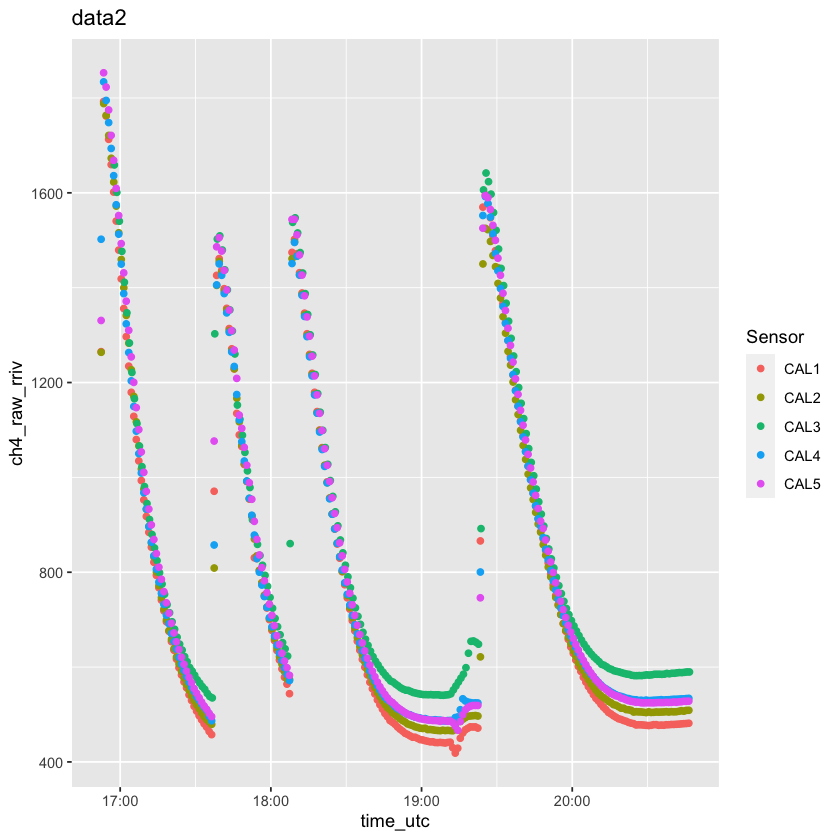

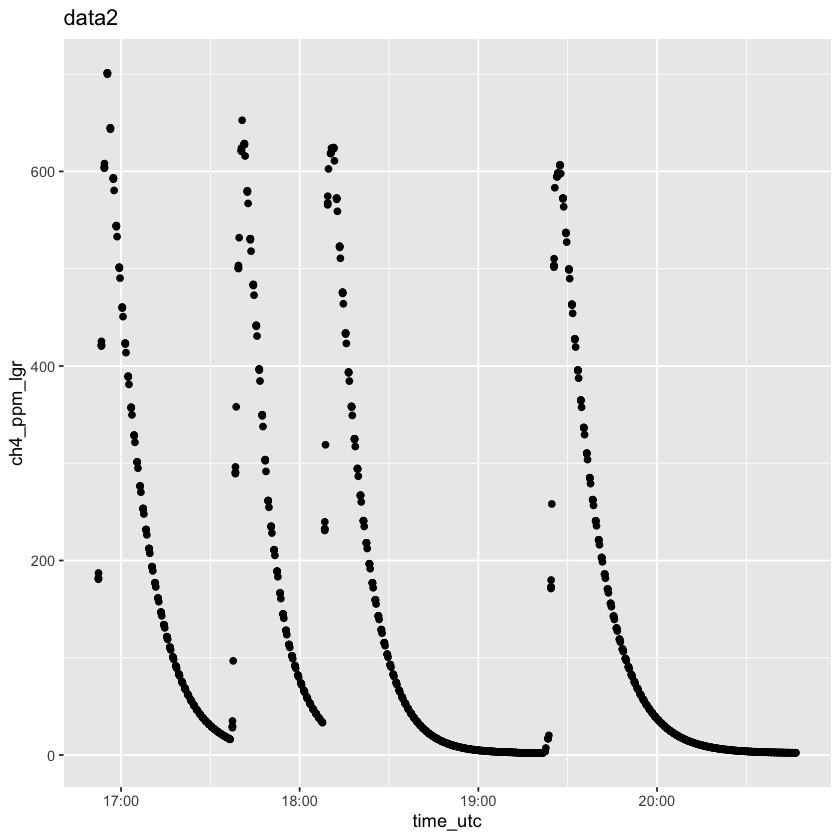

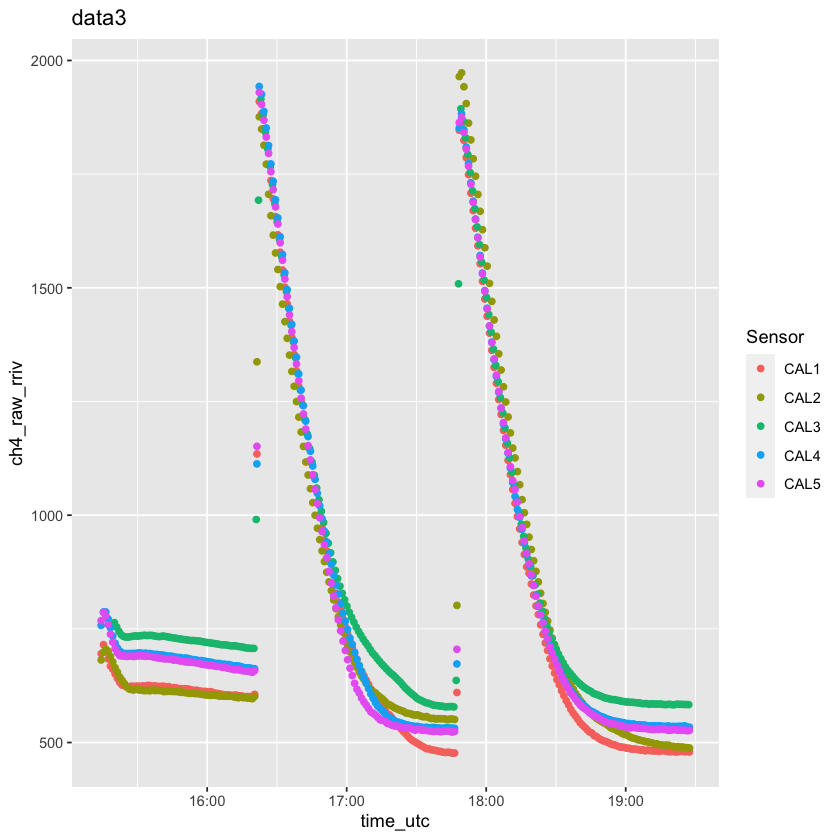

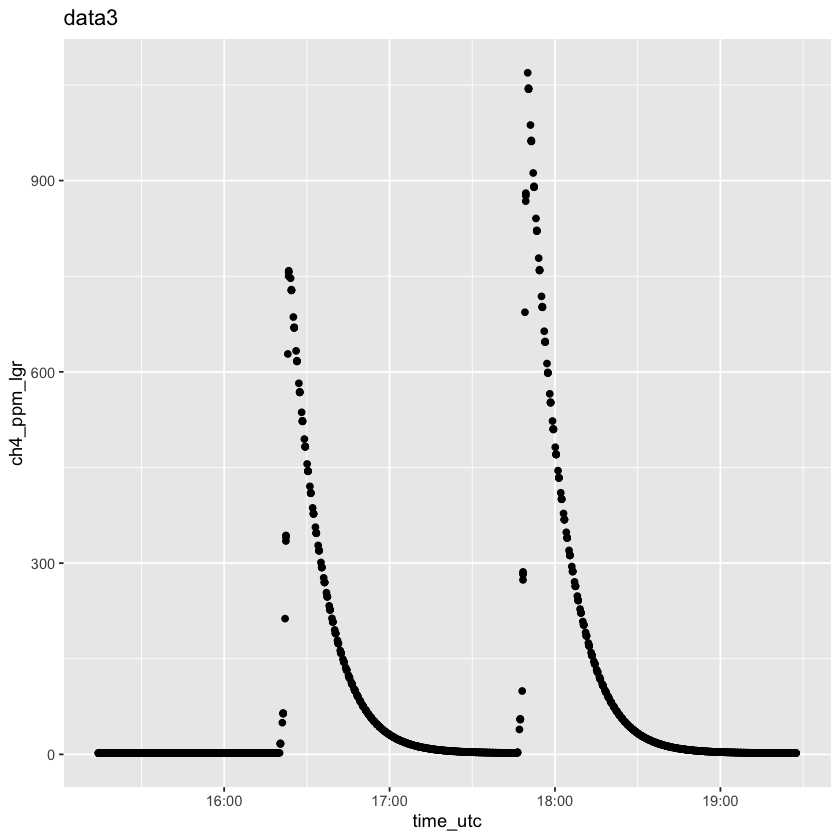

In [25]:
# ggplot(interpolated_data1, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data1")
# ggplot(interpolated_data1, aes(x=time_utc, y=ch4_ppm_lgr))+geom_point()+labs(title="data1")
# ggplot(interpolated_data1, aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+labs(title="data1")
# ggplot(interpolated_data1, aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+labs(title="data1")

# ggplot(interpolated_data1, aes(x=ch4_ppm_lgr, y=ch4_raw_rriv))+geom_point()+labs(title="data1")

ggplot(interpolated_data2, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data2")
ggplot(interpolated_data2, aes(x=time_utc, y=ch4_ppm_lgr))+geom_point()+labs(title="data2")
# ggplot(interpolated_data2, aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+labs(title="data2")
# ggplot(interpolated_data2, aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+labs(title="data2")

ggplot(interpolated_data3, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data3")
ggplot(interpolated_data3, aes(x=time_utc, y=ch4_ppm_lgr))+geom_point()+labs(title="data3")
# ggplot(interpolated_data3, aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+labs(title="data3")
# ggplot(interpolated_data3, aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+labs(title="data3")

# ggplot(interpolated_data4, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data4")
# ggplot(interpolated_data4, aes(x=time_utc, y=ch4_ppm_lgr))+geom_point()+labs(title="data4")
# ggplot(interpolated_data4, aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+labs(title="data4")
# ggplot(interpolated_data4, aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+labs(title="data4")
    

In [26]:
# head(interpolated_data1)
# head(interpolated_data2)
# head(interpolated_data3)

# 6 clean data

In [27]:
#rriv
#data1
ts1<-lubridate::as_datetime("2023-05-31 14:53:29.404")
ts2<-lubridate::as_datetime("2023-05-31 15:57:56")
interpolated_data1<-interpolated_data1[interpolated_data1$time_utc>ts1 & interpolated_data1$time_utc<ts2,]
# ggplot(interpolated_data1, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data1")
# ggplot(interpolated_data1, aes(x=time_utc, y=ch4_ppm_lgr))+geom_point()+labs(title="data1")

#data2
ts3<-lubridate::as_datetime("2023-05-31 16:59:56.06")
ts4<-lubridate::as_datetime("2023-05-31 17:36:27.897")
ts5<-lubridate::as_datetime("2023-05-31 17:45:56.06")
ts6<-lubridate::as_datetime("2023-05-31 18:07:25.053")
ts7<-lubridate::as_datetime("2023-05-31 18:16:56.06")
ts8<-lubridate::as_datetime("2023-05-31 19:11:25.314")
ts9<-lubridate::as_datetime("2023-05-31 19:32:56.06")
ts10<-lubridate::as_datetime("2023-05-31 20:47:56")
interpolated_data2_1<-interpolated_data2[interpolated_data2$time_utc>ts3 & interpolated_data2$time_utc<ts4,]
interpolated_data2_2<-interpolated_data2[interpolated_data2$time_utc>ts5 & interpolated_data2$time_utc<ts6,]
interpolated_data2_3<-interpolated_data2[interpolated_data2$time_utc>ts7 & interpolated_data2$time_utc<ts8,]
interpolated_data2_4<-interpolated_data2[interpolated_data2$time_utc>ts9 & interpolated_data2$time_utc<ts10,]
interpolated_data2<-rbind(interpolated_data2_1,interpolated_data2_2,interpolated_data2_3,interpolated_data2_4)
# ggplot(interpolated_data2, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data2")
# ggplot(interpolated_data2, aes(x=time_utc, y=ch4_ppm_lgr))+geom_point()+labs(title="data2")

#data3
ts11<-lubridate::as_datetime("2023-06-01 16:27:56.06")
ts12<-lubridate::as_datetime("2023-06-01 17:45:25.650")
ts13<-lubridate::as_datetime("2023-06-01 17:54:56.06")
ts14<-lubridate::as_datetime("2023-06-01 19:26:56")
interpolated_data3_1<-interpolated_data3[interpolated_data3$time_utc>ts11 & interpolated_data3$time_utc<ts12,]
interpolated_data3_2<-interpolated_data3[interpolated_data3$time_utc>ts13 & interpolated_data3$time_utc<ts14,]
interpolated_data3<-rbind(interpolated_data3_1,interpolated_data3_2)
# ggplot(interpolated_data3, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data3")
# ggplot(interpolated_data3, aes(x=time_utc, y=aht_C))+geom_point()+labs(title="data3")

#data4
ts15<-lubridate::as_datetime("2023-06-02 15:02:41.464")
ts16<-lubridate::as_datetime("2023-06-02 16:37:24")
interpolated_data4<-interpolated_data4[interpolated_data4$time_utc>ts15 & interpolated_data4$time_utc<ts16,]

In [28]:
#merge 
interpolated_data<-rbind(interpolated_data1,interpolated_data2,interpolated_data3,interpolated_data4)

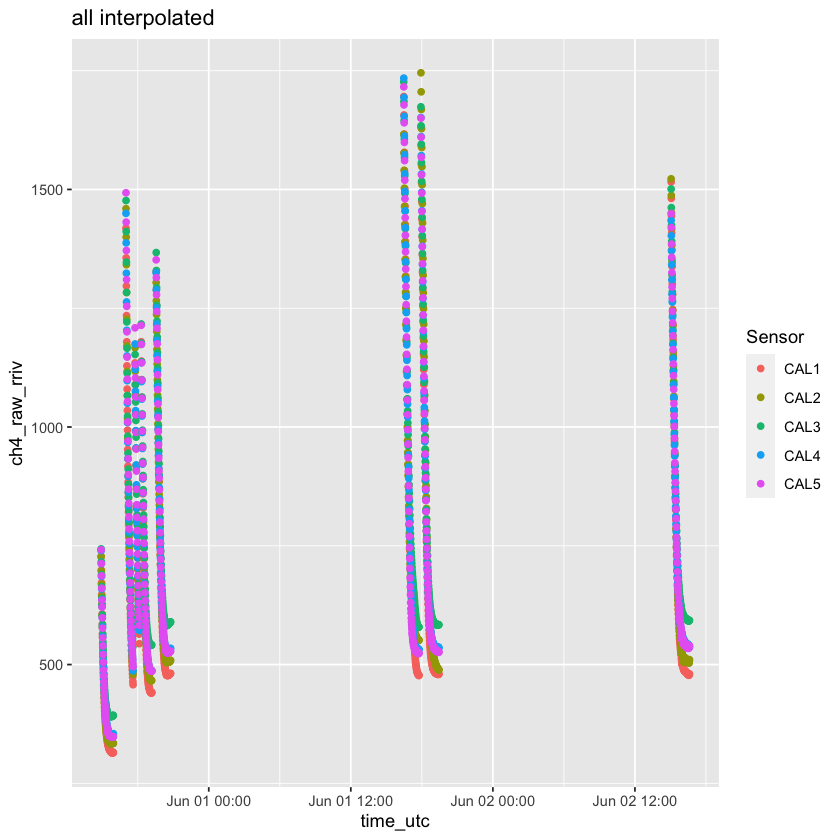

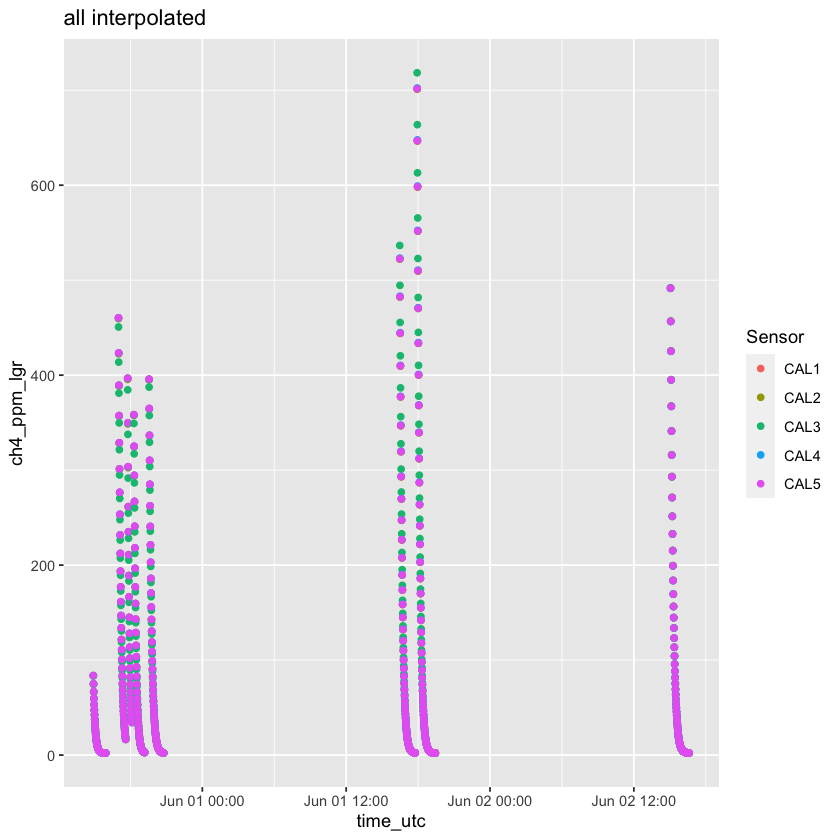

In [29]:
ggplot(interpolated_data,aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="all interpolated")
ggplot(interpolated_data,aes(x=time_utc, y=ch4_ppm_lgr, color=Sensor))+geom_point()+labs(title="all interpolated")
# ggplot(interpolated_data,aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+labs(title="all interpolated")
# ggplot(interpolated_data,aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+labs(title="all interpolated")

# ggplot(interpolated_data,aes(x=ch4_ppm_lgr, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="all interpolated")



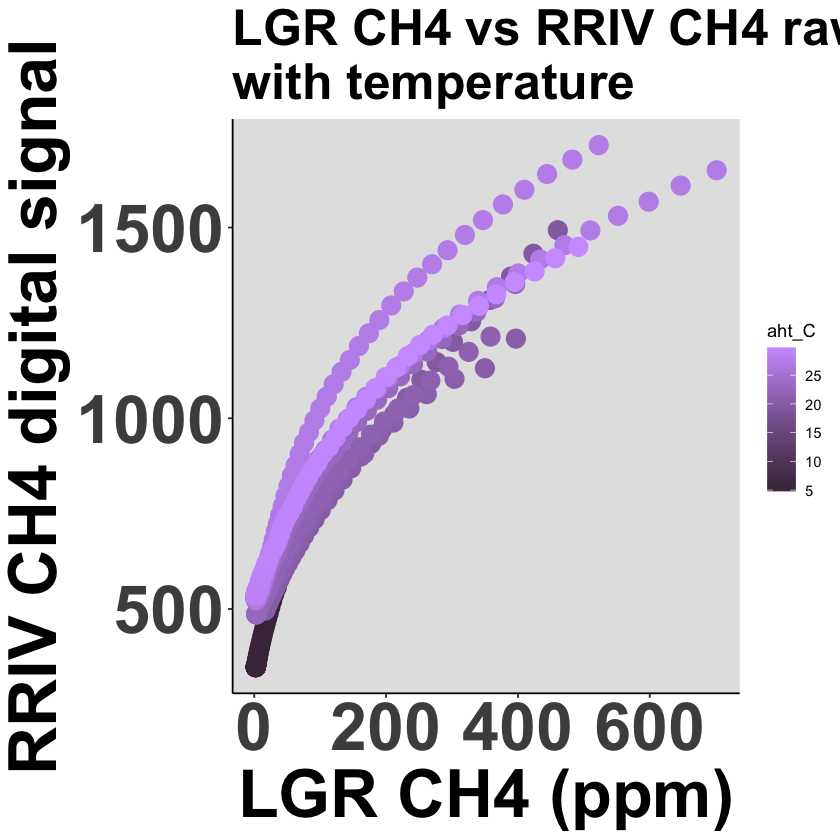

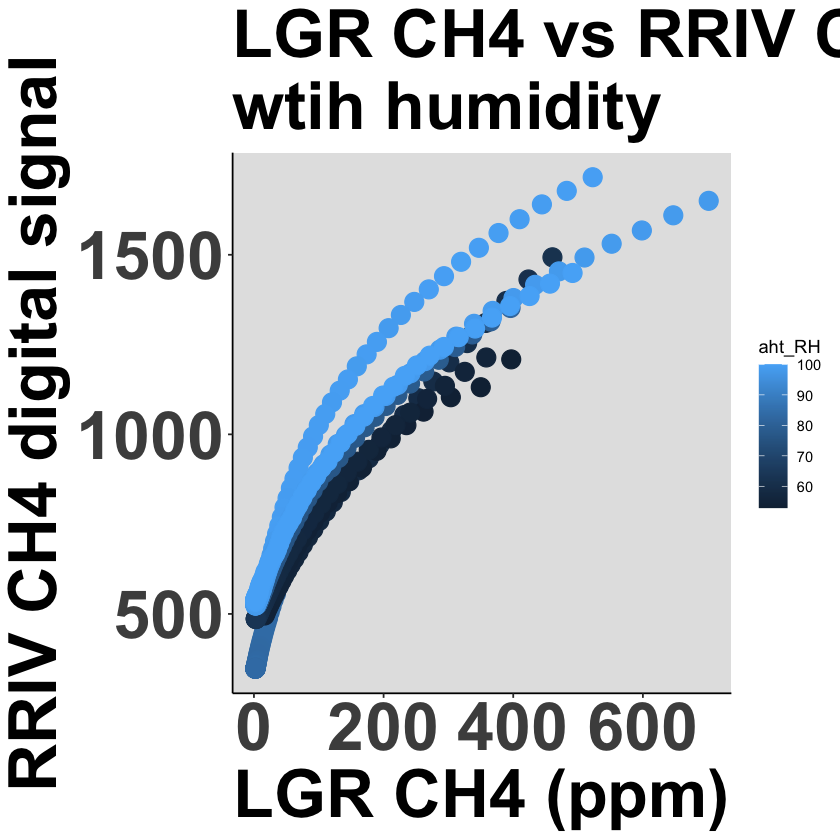

In [30]:
p1<-ggplot(interpolated_data[interpolated_data$Sensor=="CAL5",], aes(x=ch4_ppm_lgr,y=ch4_raw_rriv, color=aht_C))+
    geom_point(size=5)+scale_color_continuous(low="#483248",high="#CF9FFF")+
    theme_classic()+theme(panel.background = element_rect(fill = "#E3E3E3"))+
    labs(title="LGR CH4 vs RRIV CH4 raw\nwith temperature",x="LGR CH4 (ppm)",y="RRIV CH4 digital signal")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 30, face = "bold"))
p1
p2<-ggplot(interpolated_data[interpolated_data$Sensor=="CAL5",], aes(x=ch4_ppm_lgr,y=ch4_raw_rriv, color=aht_RH))+
    geom_point(size=5)+scale_color_continuous(type = "gradient")+
    theme_classic()+
    theme(panel.background = element_rect(fill = "#E3E3E3"))+    
    labs(title="LGR CH4 vs RRIV CH4 raw\nwtih humidity",size = 24,x="LGR CH4 (ppm)",y="RRIV CH4 digital signal")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 40, face = "bold"))
p2
# ggplot(interpolated_data[interpolated_data$Sensor=="CAL1",], aes(x=aht_C,y=ch4_raw_rriv, color=Sensor))+geom_point()
# ggplot(interpolated_data,aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="all interpolated")
# ggplot(interpolated_data,aes(x=time_utc, y=ch4_ppm_lgr, color=Sensor))+geom_point()+labs(title="all interpolated")
# ggplot(interpolated_data,aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+labs(title="all interpolated")
# ggplot(interpolated_data,aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+labs(title="all interpolated")


In [31]:
tag = "cal_raw_C"
pngPath = paste0(outputDir,"/", tag, "_", "plotName", ".png")
print(pngPath)
png(file=pngPath, width=600, height=800)
print(p1)
dev.off()
tag = "cal_raw_RH"
pngPath = paste0(outputDir,"/", tag, "_", "plotName", ".png")
print(pngPath)
png(file=pngPath, width=600, height=800)
print(p2)
dev.off()

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/cal_raw_C_plotName.png"


pdf 
  2

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/cal_raw_RH_plotName.png"


pdf 
  2

# 8. Create Models from clean data
try Rs using figaro equation, relative humidity (aht_RH) -> absolute humidity

In [52]:
# Calculate sensor resistance(Rs) using Figaro(manufacturer) equation
# Rs = (VC/VRL-1)*RL where
# VC = circuit voltage
# VRL = output voltage
# RL = load resistance
# 3-code 272 = 2.7kohm
RL = 2.7*1000  #convert kOhm to Ohm
VC = 5

# convert digital signal to voltage
interpolated_data$ch4_V=5/4096*interpolated_data$ch4_raw_rriv

# calculate sensor resistance (Rs)
interpolated_data$Rs_fig<-(VC/interpolated_data$ch4_V-1)*RL

# calculate absolute humidity from celsius and relative humidity
interpolated_data<-calcAbsoluteHumidity(interpolated_data,celsius = "aht_C",relativeHumidity = "aht_RH")

# head(interpolated_data)

## GAM

### GAM 1: ch4_ppm_lgr ~ s(ch4_raw_rriv) + s(aht_C) + s(aht_RH)

In [53]:
interpolated_cal1<-interpolated_data[interpolated_data$Sensor=="CAL1",]
interpolated_cal2<-interpolated_data[interpolated_data$Sensor=="CAL2",]
interpolated_cal3<-interpolated_data[interpolated_data$Sensor=="CAL3",]
interpolated_cal4<-interpolated_data[interpolated_data$Sensor=="CAL4",]
interpolated_cal5<-interpolated_data[interpolated_data$Sensor=="CAL5",]

gam_rriv1<-mgcv::gam(ch4_ppm_lgr~s(Rs_fig)+s(aht_C)+s(aht_RH),data=interpolated_cal1)
gam_rriv2<-mgcv::gam(ch4_ppm_lgr~s(Rs_fig)+s(aht_C)+s(aht_RH),data=interpolated_cal2)
gam_rriv3<-mgcv::gam(ch4_ppm_lgr~s(Rs_fig)+s(aht_C)+s(aht_RH),data=interpolated_cal3)
gam_rriv4<-mgcv::gam(ch4_ppm_lgr~s(Rs_fig)+s(aht_C)+s(aht_RH),data=interpolated_cal4)
gam_rriv5<-mgcv::gam(ch4_ppm_lgr~s(Rs_fig)+s(aht_C)+s(aht_RH),data=interpolated_cal5)

summary(gam_rriv1)
# summary(gam_rriv2)
# summary(gam_rriv3)
# summary(gam_rriv4)
# summary(gam_rriv5)



Family: gaussian 
Link function: identity 

Formula:
ch4_ppm_lgr ~ s(Rs_fig) + s(aht_C) + s(aht_RH)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  76.5644     0.9549   80.18   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df      F p-value    
s(Rs_fig) 8.753  8.982 681.80  <2e-16 ***
s(aht_C)  8.863  8.993  30.03  <2e-16 ***
s(aht_RH) 9.000  9.000  24.28  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.968   Deviance explained = 96.9%
GCV = 496.17  Scale est. = 469.57    n = 515

In [38]:
# vis.gam(gam_rriv1, type = "response", plot.type="persp")
# vis.gam(gam_rriv2, type = "response", plot.type="persp")
# vis.gam(gam_rriv3, type = "response", plot.type="persp")
# vis.gam(gam_rriv4, type = "response", plot.type="persp")
# vis.gam(gam_rriv5, type = "response", plot.type="persp")

In [39]:
# vis.gam(gam_rriv1,ticktype="detailed",color="heat",theta=-35)
# vis.gam(gam_rriv2,ticktype="detailed",color="heat",theta=-35)
# vis.gam(gam_rriv3,ticktype="detailed",color="heat",theta=-35)
# vis.gam(gam_rriv4,ticktype="detailed",color="heat",theta=-35)
# vis.gam(gam_rriv5,ticktype="detailed",color="heat",theta=-35)

In [40]:
# vis.gam(gam_rriv1,ticktype="detailed",color="heat",theta=50)
# vis.gam(gam_rriv2,ticktype="detailed",color="heat",theta=50)
# vis.gam(gam_rriv3,ticktype="detailed",color="heat",theta=50)
# vis.gam(gam_rriv4,ticktype="detailed",color="heat",theta=50)
# vis.gam(gam_rriv5,ticktype="detailed",color="heat",theta=50)

### GAM 2 NO C or RH

In [133]:
# gam2_rriv1<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv),data=interpolated_cal1)
# gam2_rriv2<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv),data=interpolated_cal2)
# gam2_rriv3<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv),data=interpolated_cal3)
# gam2_rriv4<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv),data=interpolated_cal4)
# gam2_rriv5<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv),data=interpolated_cal5)

# Checking predicted values

In [54]:
predict(gam_rriv1)->interpolated_cal1$predict_ch4
predict(gam_rriv2)->interpolated_cal2$predict_ch4
predict(gam_rriv3)->interpolated_cal3$predict_ch4
predict(gam_rriv4)->interpolated_cal4$predict_ch4
predict(gam_rriv5)->interpolated_cal5$predict_ch4

In [55]:
interpolated_all<-rbind(interpolated_cal1,interpolated_cal2,interpolated_cal3,interpolated_cal4,interpolated_cal5)
# interpolated_all

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


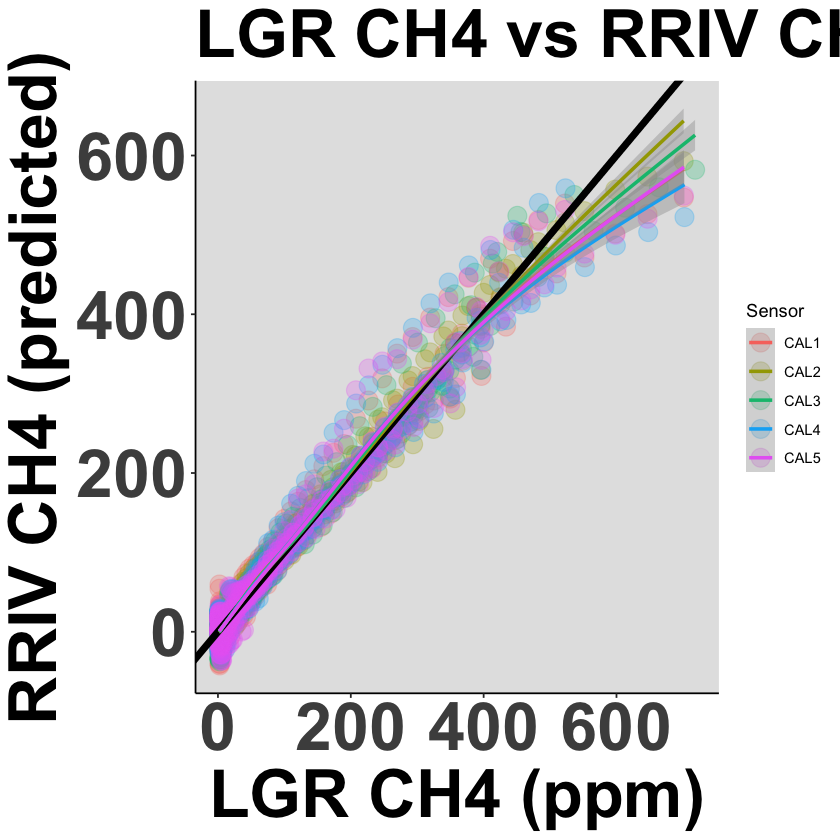

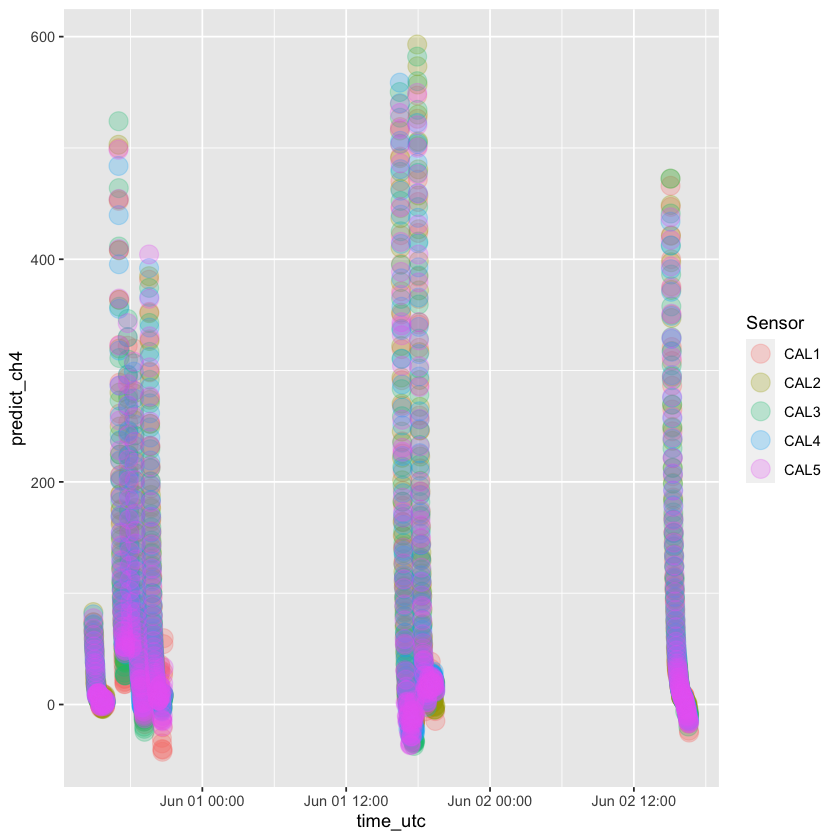

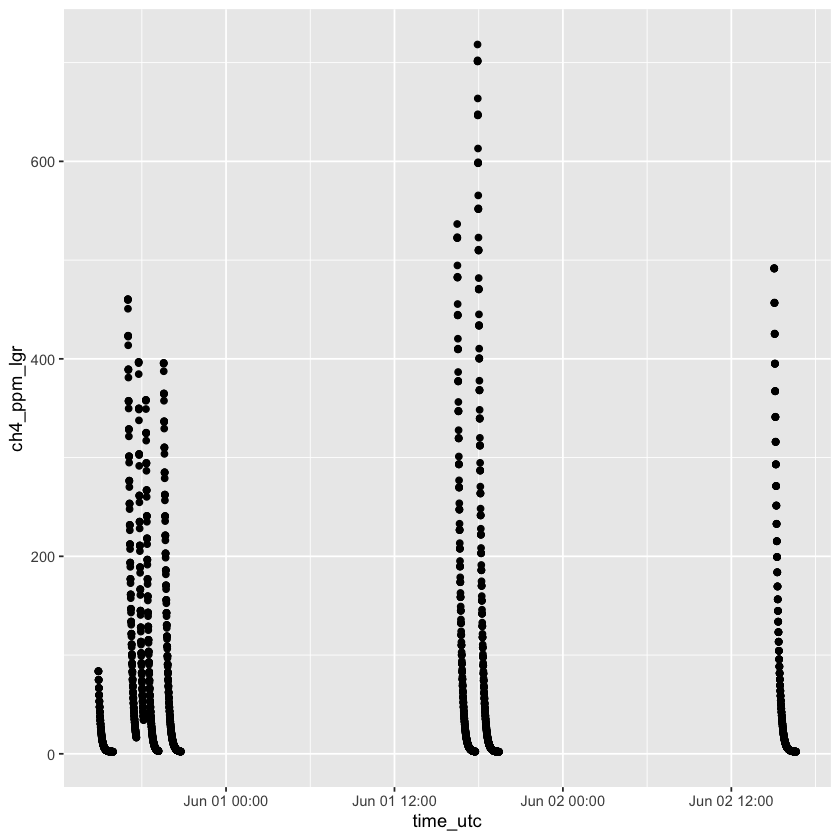

In [56]:
a<-ggplot(interpolated_all,aes(x=ch4_ppm_lgr,y=predict_ch4,color=Sensor))+geom_point(size=5,alpha=0.25)+
    geom_abline(slope = 1, linewidth=2)+geom_smooth(method="gam")+
    theme_classic()+theme(panel.background = element_rect(fill = "#E3E3E3"))+
    labs(title="LGR CH4 vs RRIV CH4 model",x="LGR CH4 (ppm)",y="RRIV CH4 (predicted)")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 40, face = "bold"))
a    
ggplot(interpolated_all,aes(x=time_utc,y=predict_ch4,color=Sensor))+geom_point(size=5,alpha=0.25)
ggplot(interpolated_all,aes(x=time_utc,y=ch4_ppm_lgr))+geom_point()

In [77]:
# str(a)

In [78]:
tag = "a"
pngPath = paste0(outputDir,"/", tag, "_", "plotName", ".png")
print(pngPath)
png(file=pngPath, width=800, height=800)
print(a)
dev.off()

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/a_plotName.png"


`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


pdf 
  2

# field test

In [57]:
#read data & align times 

#get dir
dir_pdock<-"~/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/20230530Pdock"
# read_rriv_CSV eliminates debug lines and lines where the logger is NA
pdock_rriv<-concat_dirs(dir_pdock, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
# process columns to be useful variable types, some columns may need to be done manually
pdock_rriv<-process_rriv_columns(pdock_rriv)
#add sensor col
pdock_rriv<-createSensorColFromIDs(pdock_rriv,idCol = "uuid",dict = UUIDdict)
# read_GA_ZIP is gas analyzer specific
# note, will not included viable .txt files that weren't zipped...
pdock_lgr<-concat_dirs(dir_pdock, read_GA_ZIP, filePattern=".zip", minFileSize=300)
    clean_temp()
# process time column from character
    pdock_lgr$Time<-lubridate::as_datetime(pdock_lgr$Time)
#save LGR as CSV to 20230601_output
saveDFcsv(pdock_lgr)
#time stamp align
startpd<-max(range(pdock_rriv$time.h)[1],range(pdock_lgr$Time)[1])
endpd<-min(range(pdock_rriv$time.h)[2],range(pdock_lgr$Time)[2])
pdock_rriv_overlap<-pdock_rriv[pdock_rriv$time.h>startpd & pdock_rriv$time.h<endpd,]
pdock_lgr_overlap<-pdock_lgr[pdock_lgr$Time>startpd & pdock_lgr$Time<endpd,]

pdock_rriv_ol_raw<-pdock_rriv_overlap[rriv_data1_overlap$type=="raw",]
pdock_rriv_ol_summary<-pdock_rriv_overlap[rriv_data1_overlap$type=="summary",]
# head(pdock_rriv)
# ggplot(pdock_rriv_ol_raw, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="pdock ch4 raw")
# ggplot(pdock_rriv_ol_summary, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="pdock ch4 summary")
# ggplot(pdock_lgr_overlap, aes(x=Time, y=X.CH4._ppm))+geom_point()+labs(title="pdock ch4 LGR")

[1] "Dataframe generated, manually process column types if necessary"
[1] "Dataframe generated, manually process column types if necessary"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdock_lgr.csv"


In [58]:
pdoc_interpolated<-data.frame()
for(sensor in sensorList){
    subset<-pdock_rriv_ol_summary[pdock_rriv_ol_summary$Sensor==sensor,]
#     print(subset)
    temp<-interpolateData(df1=subset,df2=pdock_lgr_overlap)
#     print(head(temp))
    temp$Sensor=sensor
    pdoc_interpolated<-rbind(pdoc_interpolated, temp)
}
saveDFcsv(pdoc_interpolated)

[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "df1 time range is larger"
[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdoc_interpolated.csv"


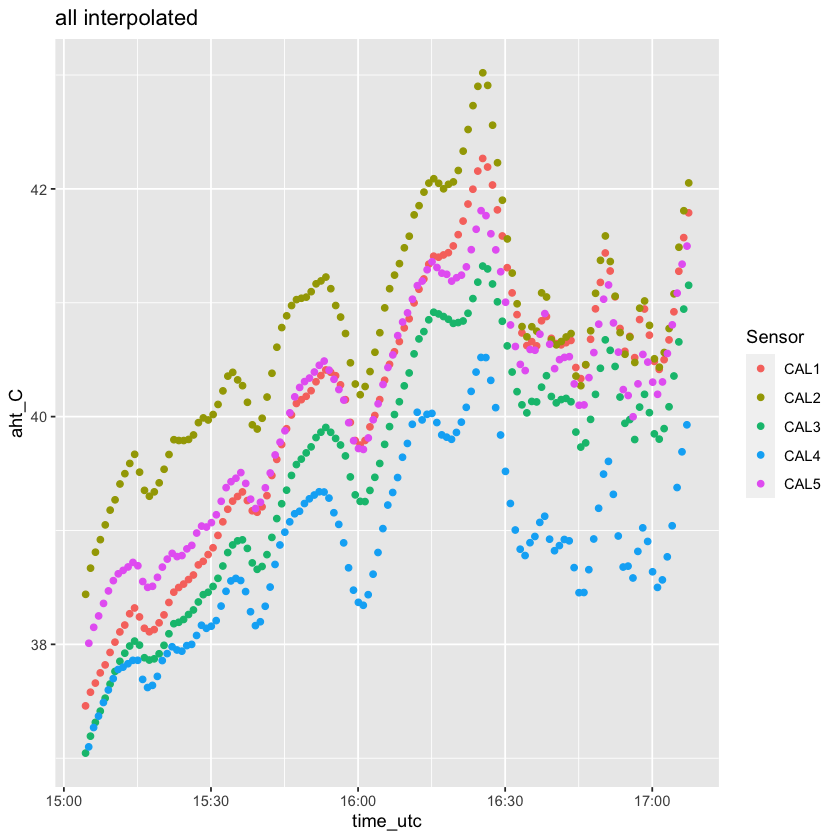

In [96]:
# pdock_raw_rriv<-ggplot(pdoc_interpolated,aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point(size=5)+
#     theme_classic()+theme(panel.background = element_rect(fill = "#FEFBEA"))+
#     labs(title="RRIV field data, May 30th",x="Time (24hr)",y="RRIV CH4 digital signal")+
#     theme(axis.text = element_text(size = 40,face="bold"), 
#         axis.title = element_text(size = 40,face="bold"),
#         plot.title = element_text(size = 45, face = "bold"))
# pdock_raw_rriv

# pdock_raw_lgr<-ggplot(pdoc_interpolated,aes(x=time_utc, y=ch4_ppm_lgr))+geom_point(size=5)+
#     theme_classic()+theme(panel.background = element_rect(fill = "#FEFBEA"))+
#     labs(title="LGR field data, May 30th",x="Time (24hr)",y="LGR CH4 (ppm)")+
#     theme(axis.text = element_text(size = 40,face="bold"), 
#         axis.title = element_text(size = 40,face="bold"),
#         plot.title = element_text(size = 45, face = "bold"))
# pdock_raw_lgr

ggplot(pdoc_interpolated,aes(x=time_utc, y=aht_C, color=Sensor))+geom_point()+labs(title="all interpolated")
# ggplot(pdoc_interpolated,aes(x=time_utc, y=aht_RH, color=Sensor))+geom_point()+labs(title="all interpolated")

In [94]:
tag = "pdock"
pngPath = paste0(outputDir,"/", tag, "_", "raw_rriv", ".png")
print(pngPath)
png(file=pngPath, width=800, height=800)
print(pdock_raw_rriv)
dev.off()
tag = "pdock"
pngPath = paste0(outputDir,"/", tag, "_", "raw_lgr", ".png")
print(pngPath)
png(file=pngPath, width=800, height=800)
print(pdock_raw_lgr)
dev.off()

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdock_raw_rriv.png"


pdf 
  2

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdock_raw_lgr.png"


pdf 
  2

In [65]:
#clean data 
ts_pd1<-lubridate::as_datetime("2023-05-30 15:09:12.167")
ts_pd2<-lubridate::as_datetime("2023-05-30 17:07:26")
pdock_clean<-pdoc_interpolated[pdoc_interpolated$time_utc>ts_pd1 & pdoc_interpolated$time_utc<ts_pd2,]


In [66]:
# Calculate sensor resistance(Rs) using Figaro(manufacturer) equation
# Rs = (VC/VRL-1)*RL where
# VC = circuit voltage
# VRL = output voltage
# RL = load resistance
# 3-code 272 = 2.7kohm
RL = 2.7*1000  #convert kOhm to Ohm
VC = 5

# convert digital signal to voltage
pdoc_interpolated$ch4_V=5/4096*pdoc_interpolated$ch4_raw_rriv

# calculate sensor resistance (Rs)
pdoc_interpolated$Rs_fig<-(VC/pdoc_interpolated$ch4_V-1)*RL

# calculate absolute humidity from celsius and relative humidity
pdoc_interpolated<-calcAbsoluteHumidity(pdoc_interpolated,celsius = "aht_C",relativeHumidity = "aht_RH")

# head(interpolated_data)

In [67]:
pdock_cal1<-pdock_clean[pdock_clean$Sensor=="CAL1",]
pdock_cal2<-pdock_clean[pdock_clean$Sensor=="CAL2",]
pdock_cal3<-pdock_clean[pdock_clean$Sensor=="CAL3",]
pdock_cal4<-pdock_clean[pdock_clean$Sensor=="CAL4",]
pdock_cal5<-pdock_clean[pdock_clean$Sensor=="CAL5",]

In [68]:
predict(gam_rriv1,pdock_cal1)->pdock_cal1$predict_ch4
predict(gam_rriv2,pdock_cal2)->pdock_cal2$predict_ch4
predict(gam_rriv3,pdock_cal3)->pdock_cal3$predict_ch4
predict(gam_rriv4,pdock_cal4)->pdock_cal4$predict_ch4
predict(gam_rriv5,pdock_cal5)->pdock_cal5$predict_ch4

# predict.gam(gam_rriv1,pdock_cal1)->pdock_cal1$predict_ch4
# predict.gam(gam_rriv2,pdock_cal2)->pdock_cal2$predict_ch4
# predict.gam(gam_rriv3,pdock_cal3)->pdock_cal3$predict_ch4
# predict.gam(gam_rriv4,pdock_cal4)->pdock_cal4$predict_ch4
# predict.gam(gam_rriv5,pdock_cal5)->pdock_cal5$predict_ch4


In [69]:
pdock_combined<-rbind(pdock_cal1,pdock_cal2,pdock_cal3,pdock_cal4,pdock_cal5)
saveDFcsv(pdock_combined)

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdock_combined.csv"


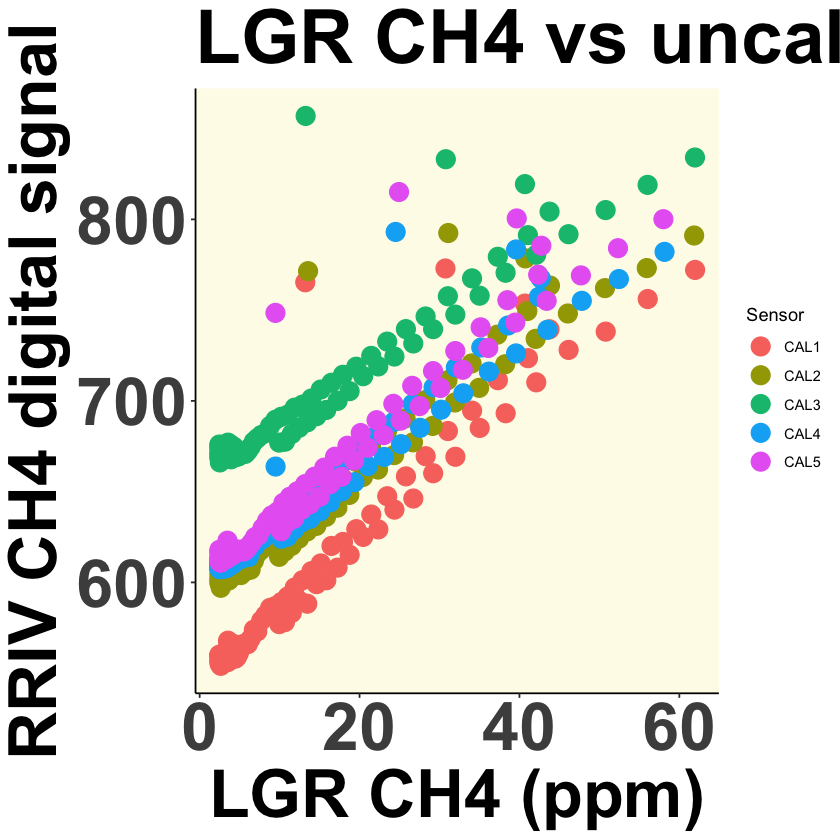

In [70]:
# names(pdock_combined)
pdock_p1<-ggplot(pdock_combined,aes(x=ch4_ppm_lgr,y=ch4_raw_rriv,color=Sensor))+geom_point(size=5)+
    theme_classic()+theme(panel.background = element_rect(fill = "#FEFBEA"))+
    labs(title="LGR CH4 vs uncalibrated field data",x="LGR CH4 (ppm)",y="RRIV CH4 digital signal")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 45, face = "bold"))
pdock_p1

In [261]:
tag = "pdock"
pngPath = paste0(outputDir,"/", tag, "_", "raw vs lgr", ".png")
print(pngPath)
png(file=pngPath, width=800, height=800)
print(pdock_p1)
dev.off()

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdock_raw vs lgr.png"


pdf 
  2

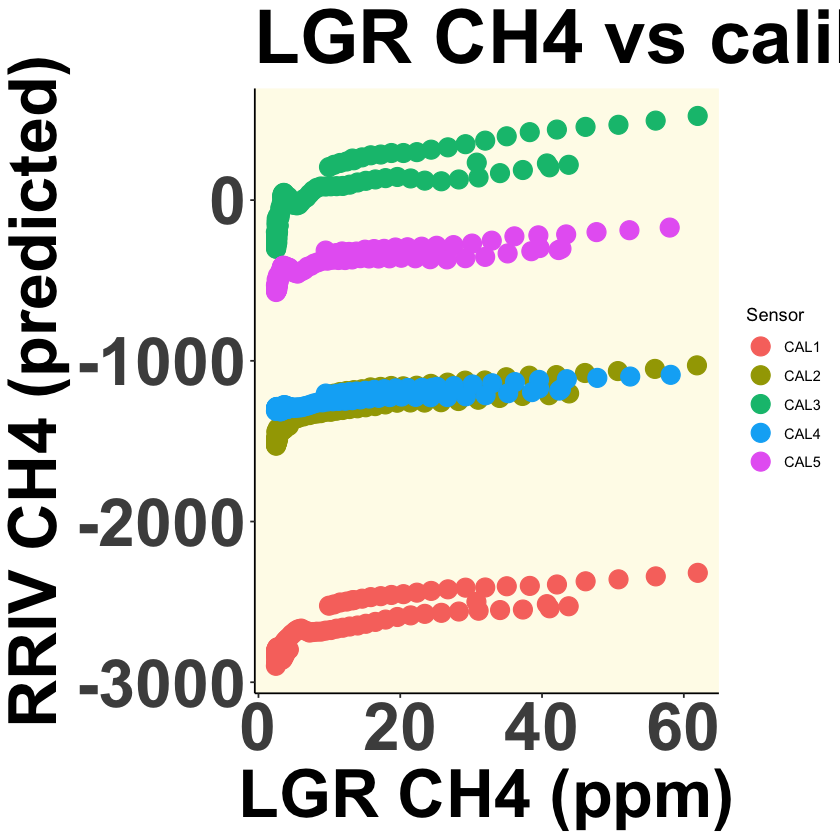

In [71]:
pdock_p2<-ggplot(pdock_combined,aes(x=ch4_ppm_lgr,y=predict_ch4,color=Sensor))+geom_point(size=5)+
    theme_classic()+theme(panel.background = element_rect(fill = "#FEFBEA"))+
    labs(title="LGR CH4 vs calibrated field data",x="LGR CH4 (ppm)",y="RRIV CH4 (predicted)")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 45, face = "bold"))
# pdock_p2+theme_classic()
pdock_p2

In [263]:
tag = "pdock"
pngPath = paste0(outputDir,"/", tag, "_", "expected vs lgr", ".png")
print(pngPath)
png(file=pngPath, width=800, height=800)
print(pdock_p2)
dev.off()

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdock_expected vs lgr.png"


pdf 
  2

# GAM2 on field data

In [227]:
predict(gam2_rriv1,pdock_cal1)->pdock_cal1$predict_ch4_2
predict(gam2_rriv2,pdock_cal2)->pdock_cal2$predict_ch4_2
predict(gam2_rriv3,pdock_cal3)->pdock_cal3$predict_ch4_2
predict(gam2_rriv4,pdock_cal4)->pdock_cal4$predict_ch4_2
predict(gam2_rriv5,pdock_cal5)->pdock_cal5$predict_ch4_2

In [228]:
pdock_combined2<-rbind(pdock_cal1,pdock_cal2,pdock_cal3,pdock_cal4,pdock_cal5)


`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


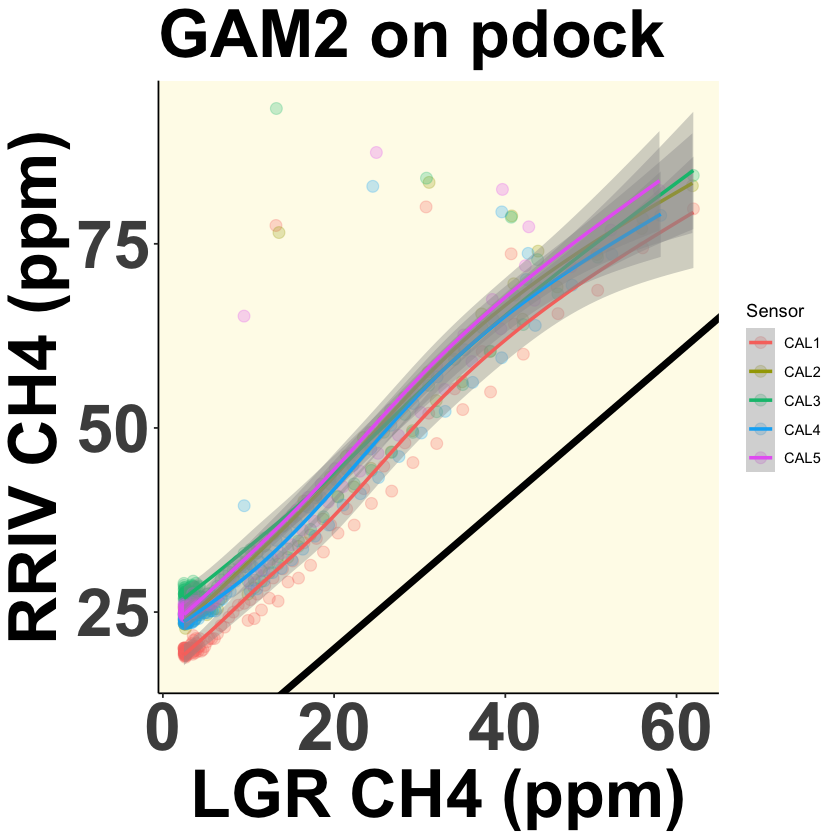

In [232]:
pdock_gam2<-ggplot(pdock_combined2,aes(x=ch4_ppm_lgr,y=predict_ch4_2,color=Sensor))+geom_point(size=3,alpha=0.25)+
    geom_abline(slope = 1, linewidth=2)+geom_smooth(method="gam")+
    theme_classic()+theme(panel.background = element_rect(fill = "#FEFBEA"))+
    labs(title="GAM2 on pdock",x="LGR CH4 (ppm)",y="RRIV CH4 (ppm)")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 40, face = "bold"))
pdock_gam2  

# GAM using field data

In [207]:
#GAM with C & RH
gam_pdock1<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=pdock_cal1)
gam_pdock2<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=pdock_cal2)
gam_pdock3<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=pdock_cal3)
gam_pdock4<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=pdock_cal4)
gam_pdock5<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=pdock_cal5)


In [220]:
predict(gam_pdock1,pdock_cal1)->pdock_cal1$predict_ch4_3
predict(gam_pdock2,pdock_cal2)->pdock_cal2$predict_ch4_3
predict(gam_pdock3,pdock_cal3)->pdock_cal3$predict_ch4_3
predict(gam_pdock4,pdock_cal4)->pdock_cal4$predict_ch4_3
predict(gam_pdock5,pdock_cal5)->pdock_cal5$predict_ch4_3
names(pdock_cal1)

[1] "time_utc"      "ch4_raw_rriv"  "aht_C"         "aht_RH"       
[5] "ch4_ppm_lgr"   "Sensor"        "predict_ch4"   "predict_ch4_2"
[9] "predict_ch4_3"

In [221]:
pdock_combined3<-rbind(pdock_cal1,pdock_cal2,pdock_cal3,pdock_cal4,pdock_cal5)


`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


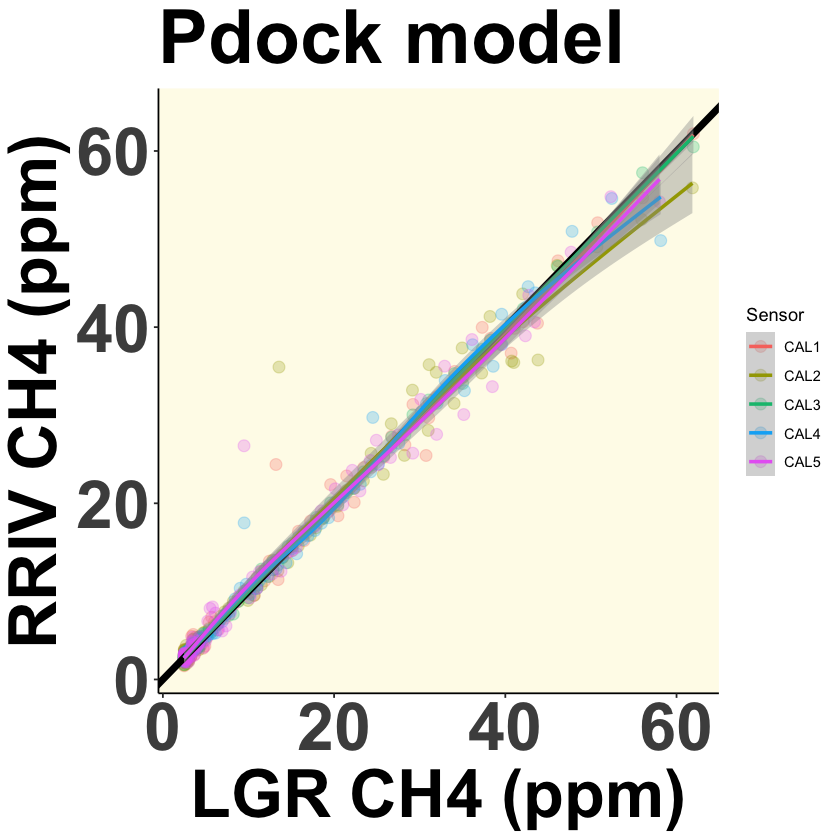

In [222]:
pd_ch4_2<-ggplot(pdock_combined3,aes(x=ch4_ppm_lgr,y=predict_ch4_3,color=Sensor))+geom_point(size=3,alpha=0.25)+
    geom_abline(slope = 1, linewidth=2)+geom_smooth(method="gam")+
    theme_classic()+theme(panel.background = element_rect(fill = "#FEFBEA"))+
    labs(title="Pdock model",x="LGR CH4 (ppm)",y="RRIV CH4 (ppm)")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 45, face = "bold"))
pd_ch4_2  

In [217]:
tag = "pdock"
pngPath = paste0(outputDir,"/", tag, "_", "linear-model", ".png")
print(pngPath)
png(file=pngPath, width=600, height=800)
print(pd_ch4_2)
dev.off()

[1] "~/Library/Mobile Documents/com~apple~CloudDocs/Documents/RRIV/Data/calibration/calibration-2023_output/pdock_linear-model.png"


`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


pdf 
  2

In [ ]:
# head(interpolated_data)
melted_data1<-melt(interpolated_cal1[,c("time_utc","ch4_ppm_lgr","predict_ch4")], id.vars="time_utc")


In [ ]:
# melted_data1

In [ ]:
# ggplot(data=melted_data1,aes(x=time_utc,y=value,color=variable))+geom_point()